In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import interpolate
from datetime import datetime, timedelta
import cmocean
from matplotlib.dates import DateFormatter
import glob
import pandas as pd
import xarray as xr
from sklearn.neighbors import LocalOutlierFactor

## load in fancy model
from sklearn import preprocessing 
import statsmodels.api as sm
import warnings; warnings.simplefilter('ignore')


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/asledd/.conda/envs/plot_env/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/asledd/.conda/envs/plot_env/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/asledd/.conda/envs/plot_env/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/asledd/.conda/envs/plot_env/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in l

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/asledd/.conda/envs/plot_env/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/asledd/.conda/envs/plot_env/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/asledd/.conda/envs/plot_env/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/asledd/.conda/envs/plot_env/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in l

AttributeError: _ARRAY_API not found

In [2]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()

    return out_vars

In [4]:
simba_filepath = '/psd3data/arctic/sledd/Raven_simba/'
# simba_fname = 'firnprofile.sled.level2.beta.15min.20240517-20240814.nc'
simba_fname = 'firnprofile-combined-corrected.sled.level2.beta.15min.20240517-20240814.nc'

season_data = {}
varnames = ['temperature','initial_height','time']
fdic = load_netcdf(simba_filepath+simba_fname, varnames)

fstart_time = datetime.strptime(fdic['time_unit'], 'minutes since %Y-%m-%d')

fdic['dates'] = np.asarray([fstart_time+timedelta(minutes=int(m)) for m in fdic['time']])

for var in ['temperature','dates','initial_height']:
    season_data[var] = fdic[var]


height coordinate is relative to the 0 surface at time of install!!!!

In [5]:
simba_temps = season_data['temperature']
simba_heights = season_data['initial_height']
simba_dates = season_data['dates']

In [6]:
vert_grad = np.gradient(simba_temps, axis=1)
second_vert_grad = np.gradient(vert_grad, axis=1)

time_grad = np.gradient(simba_temps, axis=0)
second_time_grad = np.gradient(time_grad, axis=0)

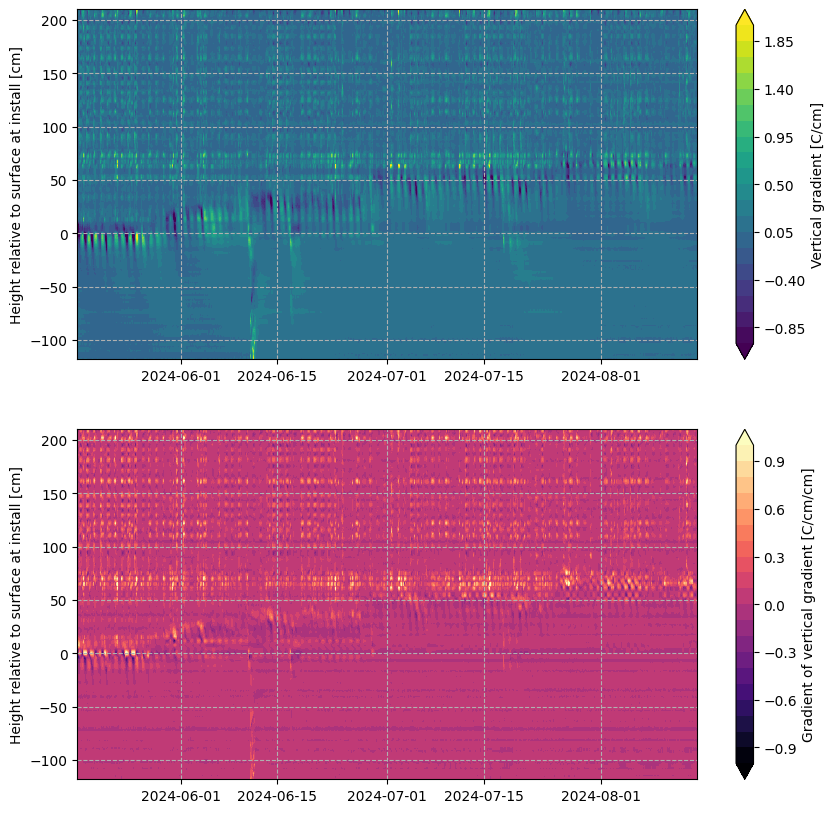

In [7]:

fig, axs = plt.subplots(2, figsize=(10,10), sharey=True)


cb = axs[0].contourf(simba_dates, simba_heights, np.swapaxes(vert_grad,0,1),
                cmap=plt.cm.viridis, levels=np.linspace(-1,2.,21), extend='both')
plt.colorbar(cb, label='Vertical gradient [C/cm]', ax=axs[0])

second_vert_profiles = np.ma.masked_outside(second_vert_grad,-200,200)
cb = axs[1].contourf(simba_dates, simba_heights, np.swapaxes(second_vert_grad,0,1),
                cmap='magma', levels=np.arange(-1,1.1,.1), extend='both')
plt.colorbar(cb, label='Gradient of vertical gradient [C/cm/cm]', ax=axs[1])


# axs[0].set_ylim(-400, -270) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax in axs.ravel():
    # ax.axhline(y=-350, c='k', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.grid(ls='--')
    ax.set_ylabel('Height relative to surface at install [cm]')
    # ax.set_xlim(datetime.datetime(2024,5,15), datetime.datetime(2024,7,30))
    

plt.show()

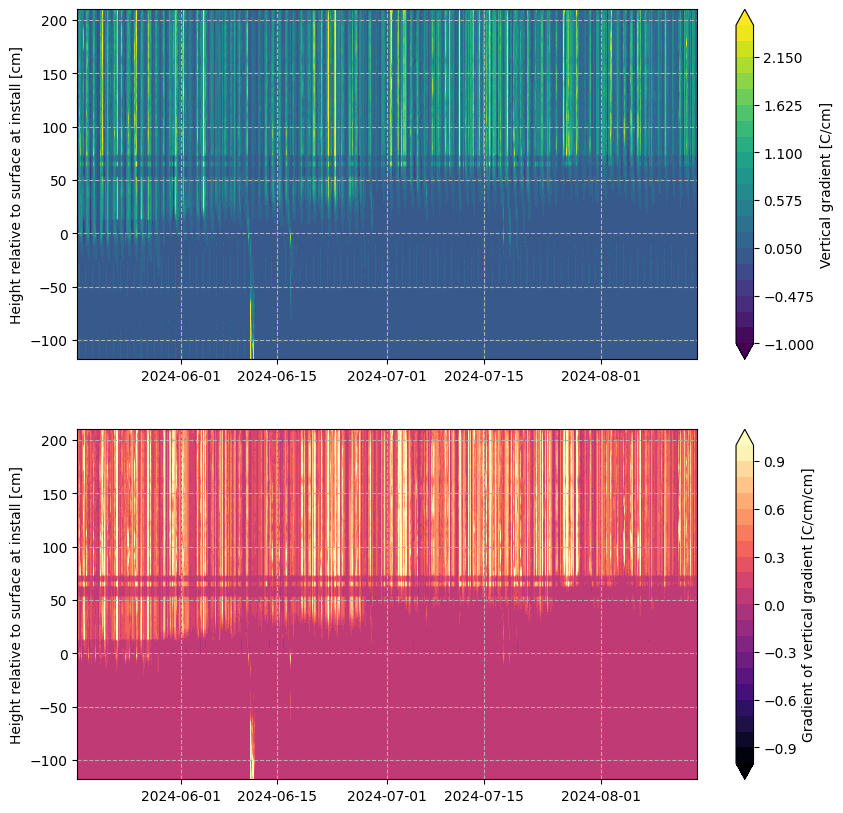

In [8]:

fig, axs = plt.subplots(2, figsize=(10,10), sharey=True)


cb = axs[0].contourf(simba_dates, simba_heights, np.swapaxes(time_grad,0,1),
                cmap=plt.cm.viridis, levels=np.linspace(-1,2.5,21), extend='both')
plt.colorbar(cb, label='Vertical gradient [C/cm]', ax=axs[0])

second_vert_profiles = np.ma.masked_outside(second_time_grad,-200,200)
cb = axs[1].contourf(simba_dates, simba_heights, np.swapaxes(second_time_grad,0,1),
                cmap='magma', levels=np.arange(-1,1.1,.1), extend='both')
plt.colorbar(cb, label='Gradient of vertical gradient [C/cm/cm]', ax=axs[1])


# axs[0].set_ylim(-400, -270) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax in axs.ravel():
    # ax.axhline(y=-350, c='k', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.grid(ls='--')
    ax.set_ylabel('Height relative to surface at install [cm]')
    # ax.set_xlim(datetime.datetime(2024,5,15), datetime.datetime(2024,7,30))
    

plt.show()

In [10]:
def get_simba_level1(start_time=datetime(2024,5,10), end_time=datetime(2024,8,23), l1_dir='/psd3data/arctic/raven/simba/level1/'):
    dates = pd.date_range(start_time, end_time)
    # lev1_files = [f'{l1_dir}/firnprofile*{d.strftime("%Y%m%d")}*.nc' for d in dates]
    # lev1_files = [f'{l1_dir}/firnprofile*.nc' for d in dates]
    lev1_files = [l1_dir+'firnprofile.sled.level2.beta.15min.20240517-20240814.nc']
    filenames = []

    # for f in lev1_files: 
    #     try: filenames.append(glob.glob(f)[0])
    #     except: 
    #         print(f"... couldnt open {f}")

    #print(filenames)
    try: 
        # ds = xr.open_mfdataset(filenames)
        ds = xr.open_mfdataset(lev1_files)

    except Exception as e:
        print(f"... couldn't open, returning file list... \n {e}")
        return filenames
    return ds

In [11]:

simba_dates = season_data['dates']
second_vert_grad = np.gradient(vert_grad, axis=1)

## Load data into pandas dataframe
sds = get_simba_level1(start_time=datetime(2024,5,17), end_time=datetime(2024,8,14), l1_dir='/psd3data/arctic/sledd/Raven_simba/')

## add second vertical temperature gradient to data frame
## why can't this be done in pandas?
sds['dT2_dH2'] = (["time", "initial_height"], second_vert_grad)
sds['dT2_dt2'] = (["time", "initial_height"], second_time_grad)

sds['multiplied'] = (["time", "initial_height"], second_time_grad*second_vert_grad)


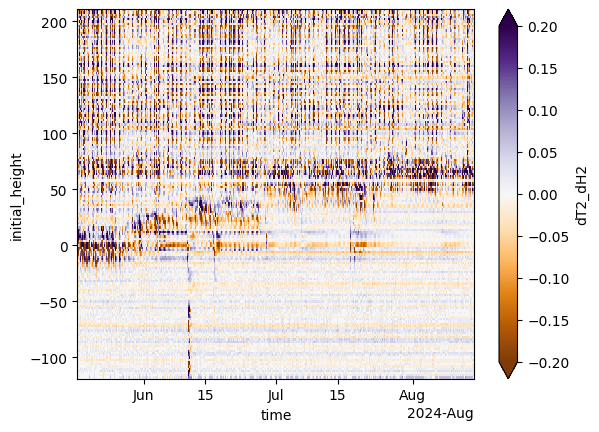

In [12]:
sds['dT2_dH2'].plot(x='time', vmin=-.2, vmax=.2, cmap='PuOr')


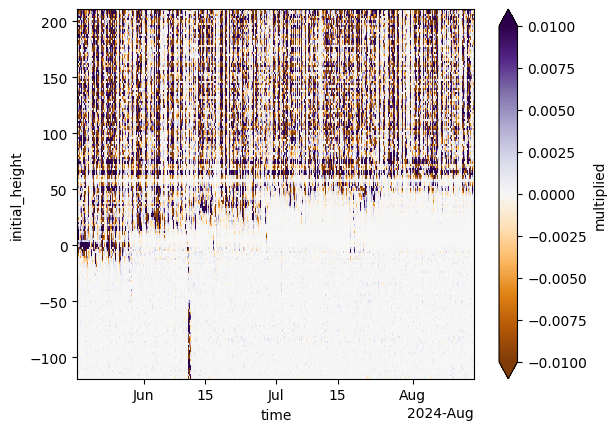

In [13]:
sds['multiplied'].plot(x='time', vmin=-.01, vmax=.01, cmap='PuOr')


In [14]:
## subset data by time (don't include after major outage)
## subsetting by height matters! remove noisier levels above surface and include more below

## try working on before july 1 and after separately
# ds_slice = sds.loc[dict(time=slice(datetime(2024,5,17),datetime(2024,8,14)), initial_height=slice(-100,75))]
ds_slice = sds.loc[dict(time=slice(datetime(2024,5,17),datetime(2024,7,1)), initial_height=slice(-100,60))]

# df = ds_slice['dT2_dH2'].to_pandas().transpose()
df = ds_slice['multiplied'].to_pandas().transpose()

df = df.mask((ds_slice['dT2_dt2'].transpose()<0.1)&(ds_slice['initial_height']<20)&(ds_slice['time']>datetime(2024,6,15)), 0.)

In [15]:
## removing columns that have nans in them (missing data in above plot)
print(df.index)
print(df.columns)
print(df)

for c in df.columns:
    if df[c].isna().sum()>0:
        df = df.drop([c], axis=1)

print(df)

Index([-100,  -98,  -96,  -94,  -92,  -90,  -88,  -86,  -84,  -82,  -80,  -78,
        -76,  -74,  -72,  -70,  -68,  -66,  -64,  -62,  -60,  -58,  -56,  -54,
        -52,  -50,  -48,  -46,  -44,  -42,  -40,  -38,  -36,  -34,  -32,  -30,
        -28,  -26,  -24,  -22,  -20,  -18,  -16,  -14,  -12,  -10,   -8,   -6,
         -4,   -2,    0,    2,    4,    6,    8,   10,   12,   14,   16,   18,
         20,   22,   24,   26,   28,   30,   32,   34,   36,   38,   40,   42,
         44,   46,   48,   50,   52,   54,   56,   58,   60],
      dtype='int64', name='initial_height')
DatetimeIndex(['2024-05-17 00:00:00', '2024-05-17 00:15:00',
               '2024-05-17 00:30:00', '2024-05-17 00:45:00',
               '2024-05-17 01:00:00', '2024-05-17 01:15:00',
               '2024-05-17 01:30:00', '2024-05-17 01:45:00',
               '2024-05-17 02:00:00', '2024-05-17 02:15:00',
               ...
               '2024-06-30 21:45:00', '2024-06-30 22:00:00',
               '2024-06-30 22:15:00

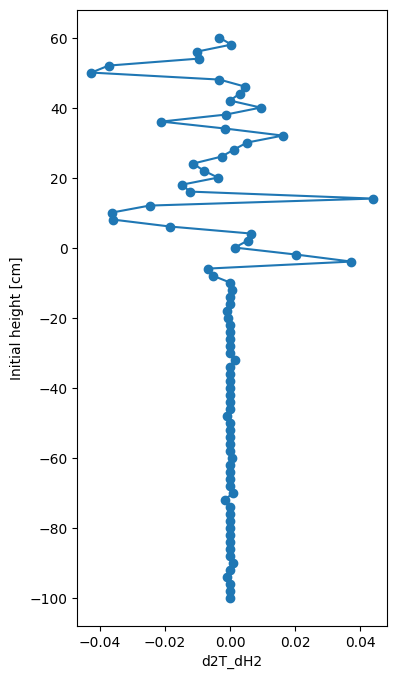

In [16]:
## Example of profile that looks like it should have an anomaly
fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)

for c in df.columns:
    axs.plot(df[c],df.index, marker='o')
    axs.set_ylabel('Initial height [cm]')
    axs.set_xlabel('d2T_dH2')
    break

In [27]:
# runnning our fancy model: removing profiles that have significant white noise based on pvalues
pvals = []

mms = preprocessing.MinMaxScaler((-1,1))
# m = mms.fit_transform(df.transpose().values)
# df_scaled[:] = mms.fit_transform(df.transpose().values).transpose()
df_filtered = df.copy()
lb_test_results = []

p_threshold = 1.*10**-3 # way less noisy with smoothed profiles; tried -15

print("... beginning ARIMA tests for noise quantification...")
args_list = []

def run_noise_test(dff, icol):
    
    # p_threshold=0.00001# 0.00001
    if icol % 500 == 0: print(f"... still running {icol} !!")
    
    # pass me a single column of data
    try: 
        arima_res = sm.tsa.ARIMA(dff).fit()
        jb_res = sm.stats.acorr_ljungbox(arima_res.resid, return_df=True)
        pval_mean = jb_res['lb_pvalue'].mean()
        if  pval_mean > p_threshold: # original threshold: 0.00001
            return True, dff.name, pval_mean
        else:
            return False, dff.name, pval_mean
    except Exception as e:
        print(f"... testing {dff.name} failed")
        return True, dff.name, np.nan

args_list = [(df_filtered[c], icol) for icol,c in enumerate(df.columns)]
    
#for icol,c in enumerate(df.columns):
    # args_list.append((df_filtered[c], ))
    
    # arima_res = sm.tsa.ARIMA(df_filtered[c]).fit()
    # jb_res = sm.stats.acorr_ljungbox(arima_res.resid, return_df=True)
    # lb_test_results.append(jb_res)
    # pvals.append(jb_res['lb_pvalue'].mean())
    # if jb_res['lb_pvalue'].mean() > p_threshold: # original threshold: 0.00001
    #     df_filtered[c] = np.nan

import multiprocessing
with multiprocessing.Pool(processes=24) as pool:
    results = pool.starmap(run_noise_test, args_list)

pvals = []
for test_result, column_name, pval_mean in results:
    pvals.append(pval_mean)
    if test_result == True:
        df_filtered[column_name] = np.nan

... beginning ARIMA tests for noise quantification...
... still running 0 !!
... still running 1000 !!
... still running 500 !!
... still running 1500 !!
... still running 2000 !!
... still running 2500 !!
... still running 3000 !!
... still running 3500 !!
... still running 4000 !!


In [28]:
def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins)
  plt.xscale('log')

In [29]:
print(np.percentile(pvals,50))

8.702917871851211e-05


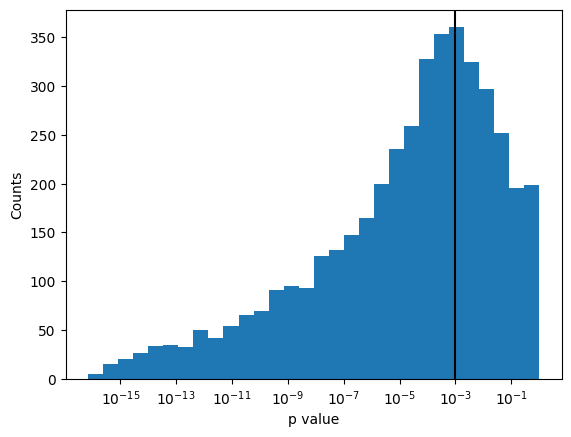

In [30]:
plot_loghist(pvals, 30)
plt.xlabel('p value')
plt.ylabel('Counts')
plt.axvline(x=p_threshold, c='k')
plt.show()

In [31]:
num_nan = df_filtered.isna().sum().sum()
num_tot = len(df_filtered)*len(df_filtered.iloc[0])
print(f" !!! threw out {np.round((num_nan/num_tot)*100,2)}% data points!!!")

 !!! threw out 34.07% data points!!!


In [32]:
# fig, axs = plt.subplots(1,1, figsize=(4,10), sharey=True)

# for c in df.columns:
#     axs.plot(df_filtered[c],df_filtered.index)

In [33]:
# ## THIS DOESN'T RUN IN ORDER!
# fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)
# times = pd.DataFrame(anoms.columns)

# prev_day = anoms.columns[0].floor("D")
# for i, c in enumerate(anoms.columns):
#     curr_day = c.floor("D") 
#     if curr_day>prev_day: 
#         prev_day = curr_day
#         fig.savefig(f"plots/surface_anom_tests_filtered_{c.strftime('%Y%m%d')}.png")
#         plt.close(fig)
#         fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)
#     else:
#         #axs.plot(anoms[c],anoms.index, color='sienna', alpha=0.4)
#         axs.plot(df_filtered[c],dfs.index, color='cadetblue', alpha=0.4)
    

In [34]:
# drop nan columns
dff = df_filtered.copy()
for c in dff.columns:
    if dff[c].isna().sum()>0:
        dff = dff.drop([c], axis=1)

HERE: trying to understand if .transpose() if doing what we want

In [35]:
t_dff = dff.copy()
print(t_dff.index)
t_dff = t_dff.transpose()
print(t_dff.index)

Index([-100,  -98,  -96,  -94,  -92,  -90,  -88,  -86,  -84,  -82,  -80,  -78,
        -76,  -74,  -72,  -70,  -68,  -66,  -64,  -62,  -60,  -58,  -56,  -54,
        -52,  -50,  -48,  -46,  -44,  -42,  -40,  -38,  -36,  -34,  -32,  -30,
        -28,  -26,  -24,  -22,  -20,  -18,  -16,  -14,  -12,  -10,   -8,   -6,
         -4,   -2,    0,    2,    4,    6,    8,   10,   12,   14,   16,   18,
         20,   22,   24,   26,   28,   30,   32,   34,   36,   38,   40,   42,
         44,   46,   48,   50,   52,   54,   56,   58,   60],
      dtype='int64', name='initial_height')
DatetimeIndex(['2024-05-17 00:15:00', '2024-05-17 00:30:00',
               '2024-05-17 01:00:00', '2024-05-17 01:15:00',
               '2024-05-17 01:30:00', '2024-05-17 01:45:00',
               '2024-05-17 02:00:00', '2024-05-17 03:00:00',
               '2024-05-17 03:15:00', '2024-05-17 03:30:00',
               ...
               '2024-06-30 20:00:00', '2024-06-30 20:15:00',
               '2024-06-30 20:30:00

In [36]:
# do the normalization/scaling in the horizontal for bumping signal to noise ratio
# rsdf = dff.copy()
# mms = preprocessing.RobustScaler(quantile_range=(0.4,0.6),with_centering=True)
# m = mms.fit_transform(rsdf.transpose()) # original with transpose()
# dfs = pd.DataFrame(m.transpose(), columns=dff.columns,index=dff.index) # original with transpose


In [37]:
# this is scaling in the vertical but seems worse than horizontal
rsdf = dff.copy()
mms = preprocessing.RobustScaler(quantile_range=(0.1,0.9),with_centering=True)
m = mms.fit_transform(rsdf) # original with transpose()
dfs = pd.DataFrame(m, columns=rsdf.columns,index=rsdf.index)

In [38]:
# fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)

# for c in dfs.columns:
#     axs.plot(dfs[c],dfs.index)



Idea from michael: daily average sample???

In [39]:
model = LocalOutlierFactor(n_neighbors=20, contamination=0.35) # 20
model.fit(dfs)
y_pred = model.fit_predict(dfs)
anoms = dfs[y_pred==-1]

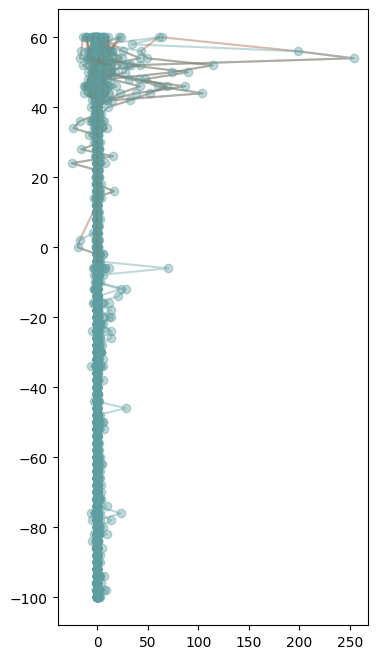

In [40]:
fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)
times = pd.DataFrame(anoms.columns)

prev_day = anoms.columns[0].floor("D")
for i, c in enumerate(anoms.columns):
    curr_day = c.floor("D") 
    if curr_day>prev_day: 
        prev_day = curr_day
        fig.savefig(f"plots/surface_anom_tests_scaled_{c.strftime('%Y%m%d')}.png")
        plt.close(fig)
        fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)
    else:
        axs.plot(anoms[c],anoms.index, color='sienna', alpha=0.4)
        axs.plot(dfs[c],dfs.index, color='cadetblue', alpha=0.4, marker='o')
        #axs.plot.scatter(dfs[c],dfs.index, color='cadetblue', alpha=0.4)

    

In [41]:
# the algorithm drops anything it doesn't identify as anomalous in height, recreate with np.nan in those places
fixed_anoms = df.copy()
fixed_anoms[:] = np.nan
aa = anoms.copy()
for c in anoms.columns:
    fixed_anoms.loc[anoms[c].index, c] = anoms[c]


In [42]:
aa = pd.DataFrame(columns=fixed_anoms.columns, index=['max_val','max_index'])

for c in fixed_anoms:
    max_i = fixed_anoms[c].abs().idxmax()
    max_v   = fixed_anoms[c].abs().max()
    aa.loc['max_val',c] = max_v
    aa.loc['max_index',c] = max_i

In [43]:
aa

time,2024-05-17 00:00:00,2024-05-17 00:15:00,2024-05-17 00:30:00,2024-05-17 00:45:00,2024-05-17 01:00:00,2024-05-17 01:15:00,2024-05-17 01:30:00,2024-05-17 01:45:00,2024-05-17 02:00:00,2024-05-17 02:15:00,...,2024-06-30 21:45:00,2024-06-30 22:00:00,2024-06-30 22:15:00,2024-06-30 22:30:00,2024-06-30 22:45:00,2024-06-30 23:00:00,2024-06-30 23:15:00,2024-06-30 23:30:00,2024-06-30 23:45:00,2024-07-01 00:00:00
max_val,NaN,8.539647,45.015358,NaN,507.194305,4.268283,20.428872,254.732112,913.204755,NaN,...,12.063171,NaN,NaN,NaN,NaN,17.709919,NaN,7.278623,NaN,NaN
max_index,NaN,14,-2,NaN,14,12,12,-2,-2,NaN,...,44,NaN,NaN,NaN,NaN,50,NaN,54,NaN,NaN


... successfully calculated surface height for timestep 2024-05-18 00:00:00
... successfully calculated surface height for timestep 2024-05-19 00:00:00
... successfully calculated surface height for timestep 2024-05-20 00:15:00
... successfully calculated surface height for timestep 2024-05-21 00:30:00
... successfully calculated surface height for timestep 2024-05-22 00:15:00
... successfully calculated surface height for timestep 2024-05-23 00:15:00
... successfully calculated surface height for timestep 2024-05-24 00:00:00
... successfully calculated surface height for timestep 2024-05-25 01:30:00
... successfully calculated surface height for timestep 2024-05-26 02:45:00
... successfully calculated surface height for timestep 2024-05-27 01:00:00
... successfully calculated surface height for timestep 2024-05-28 00:00:00
... successfully calculated surface height for timestep 2024-05-29 01:00:00
... successfully calculated surface height for timestep 2024-05-30 00:00:00
... successf

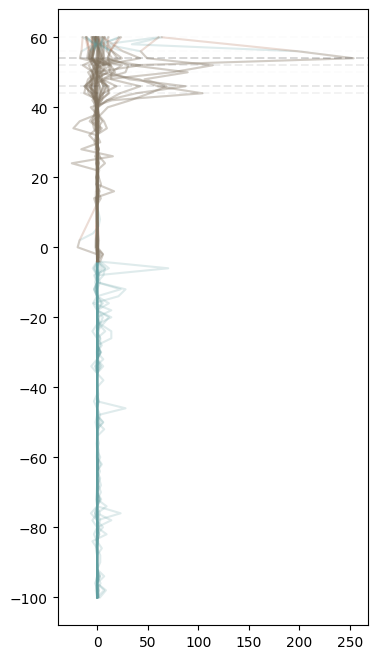

In [44]:
fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)
times = pd.DataFrame(anoms.columns)

prev_day = anoms.columns[0].floor("D")
day_success = False

for i, c in enumerate(anoms.columns):

    curr_day = c.floor("D") 
    if curr_day>prev_day: 
        prev_day = curr_day
        fig.savefig(f"plots/surface_anom_tests_scaled_{c.strftime('%Y%m%d')}.png")
        plt.close(fig)
        fig, axs = plt.subplots(1,1, figsize=(4,8), sharey=True)
        if day_success: print(f"... successfully calculated surface height for timestep {c}")
        day_success = False
    else:
        axs.plot(dfs[c],dfs.index, color='cadetblue', alpha=0.2)
        axs.plot(anoms[c],anoms.index, color='sienna', alpha=0.2)
        try: 
            axs.axhline(y=aa.loc['max_index',c], color="black", linestyle="--",alpha=0.01)
            if day_success==False: 
                day_success = True
        except: 
            do_nothing = True
        #axs.plot.scatter(dfs[c],dfs.index, color='cadetblue', alpha=0.4)

In [45]:
def despike_rolling(df_column, window=10, threshold=3):
    rolling_median = df_column.rolling(window=window, center=True, min_periods=1).median()
    rolling_std = df_column.rolling(window=window, center=True, min_periods=1).std()
    df_clean = df_column[np.abs(df_column - rolling_median) <= (threshold * rolling_std)]
    return df_clean

In [46]:
print(aa)

time      2024-05-17 00:00:00 2024-05-17 00:15:00 2024-05-17 00:30:00  \
max_val                   NaN            8.539647           45.015358   
max_index                 NaN                  14                  -2   

time      2024-05-17 00:45:00 2024-05-17 01:00:00 2024-05-17 01:15:00  \
max_val                   NaN          507.194305            4.268283   
max_index                 NaN                  14                  12   

time      2024-05-17 01:30:00 2024-05-17 01:45:00 2024-05-17 02:00:00  \
max_val             20.428872          254.732112          913.204755   
max_index                  12                  -2                  -2   

time      2024-05-17 02:15:00  ... 2024-06-30 21:45:00 2024-06-30 22:00:00  \
max_val                   NaN  ...           12.063171                 NaN   
max_index                 NaN  ...                  44                 NaN   

time      2024-06-30 22:15:00 2024-06-30 22:30:00 2024-06-30 22:45:00  \
max_val                   NaN   

In [47]:
## make time the index so that you can use groupby to get daily/hourly/whatever statistics
aa_formated = aa.copy().transpose()

In [48]:
print(aa_formated)

                        max_val max_index
time                                     
2024-05-17 00:00:00         NaN       NaN
2024-05-17 00:15:00    8.539647        14
2024-05-17 00:30:00   45.015358        -2
2024-05-17 00:45:00         NaN       NaN
2024-05-17 01:00:00  507.194305        14
...                         ...       ...
2024-06-30 23:00:00   17.709919        50
2024-06-30 23:15:00         NaN       NaN
2024-06-30 23:30:00    7.278623        54
2024-06-30 23:45:00         NaN       NaN
2024-07-01 00:00:00         NaN       NaN

[4303 rows x 2 columns]


In [49]:
aa_6h = aa_formated.groupby(pd.Grouper(freq='6H'))

## .quantiles not playing nice with .groupy()?
aa_min_6h = []

for group in aa_6h:
    g = group[1]['max_index']#.values
    # print(g.quantile(0.25), g.quantile(0.75))

    # print(g['max_index'].between(-350,-340))
    middle_g = g[g.between(g.quantile(0.25), g.quantile(0.75))]
    print(middle_g.min())
    # group_middle = g.between(g.transform('quantile', 0.25), g.transform('quantile', 0.75))
    aa_min_6h.append(middle_g.min())

-2
-2
-2
0
-4
0
0
-4
-2
-2
0
-2
-4
0
0
0
0
-2
-2
36
-4
14
0
14
-2
0
0
-2
-4
0
0
30
0
0
0
-2
14
0
-2
-4
0
-2
26
0
16
16
14
0
20
24
44
16
16
36
16
20
16
16
22
24
20
26
26
26
26
22
20
26
26
28
22
24
24
24
22
22
24
26
22
20
36
28
26
38
50
36
24
20
30
26
18
50
36
34
46
36
36
38
42
-2
-4
24
36
36
36
38
26
32
40
40
32
38
34
34
32
34
34
36
30
28
32
32
30
-4
32
26
22
22
-2
36
48
44
40
38
40
42
40
38
42
28
36
38
38
36
36
38
38
36
34
34
36
36
36
36
38
38
38
40
50
50
36
40
50
34
34
36
38
48
nan
54
32
26
34
50
52
48
54
54
46
46
nan


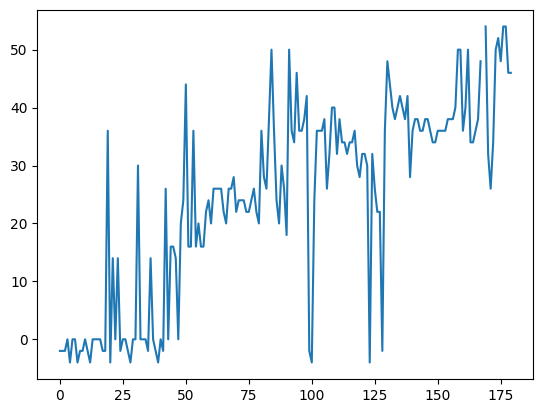

In [50]:
plt.plot(aa_min_6h)

In [51]:
aa_mode = aa_formated.groupby(pd.Grouper(freq='24H'))#.mode()
aa_min = aa_formated.groupby(pd.Grouper(freq='6H')).min()
aa_med = aa_formated.groupby(pd.Grouper(freq='6H')).median()


## groupby doesn't have option for mode???

days = []
modal_height = []

for item in aa_mode:
    days.append(item[1].index[0].date() )
    # print(item[1].index[0])
    # print(item[1]['max_index'].mode().values.min())
    try: 
        modal_height.append(item[1]['max_index'].mode().values.min())
    except:
        modal_height.append(np.nan)
    # print(item[1]['max_index'].mode().values)
# print(aa_mode)
modal_height = np.asarray(modal_height)
days = np.asarray(days)

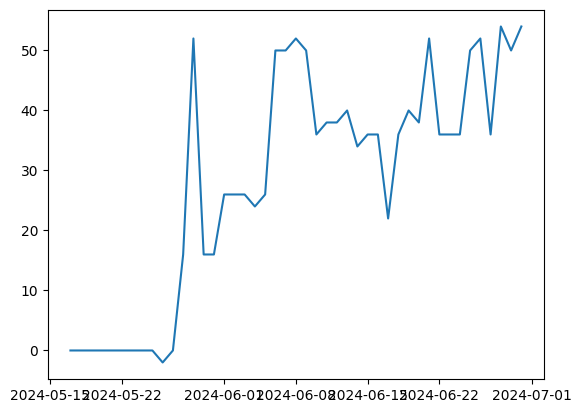

In [52]:
plt.plot(days,modal_height)

In [53]:
despike_aa = despike_rolling(aa_min['max_index'],window=4*18, threshold=.6) #window=4*18, threshold=1)
despike_raw = despike_rolling(aa.loc['max_index',:], window=4*18, threshold=1)
# despike_mode = despike_rolling(modal_height, window=4*18, threshold=1)

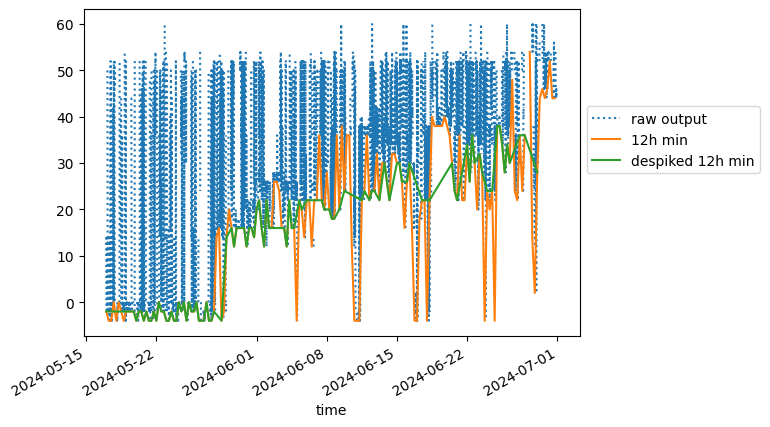

In [54]:
aa.loc['max_index',:].plot(ls=':', label='raw output')
aa_min.loc[:,'max_index'].plot(label='12h min')# plt.plot(days, modal_height, label='12h mode')
despike_aa.plot(label='despiked 12h min')
plt.legend(loc='center left', bbox_to_anchor=(1,.6))


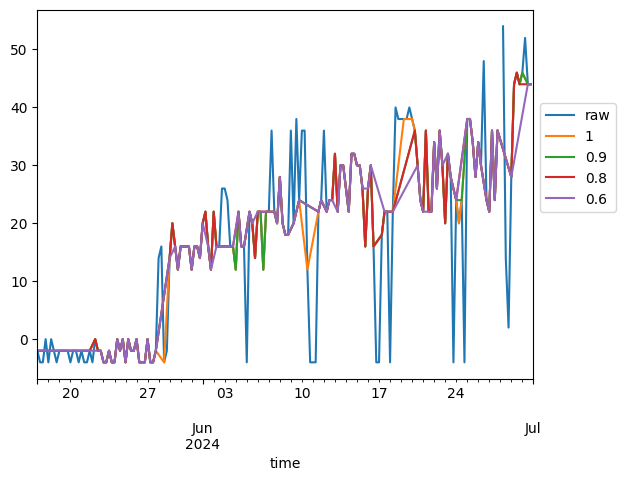

In [55]:
aa_min['max_index'].plot(label='raw')
for t in [1,.9,.8,.6]:
    despike_t = despike_rolling(aa_min['max_index'],window=4*12, threshold=t) #window=4*18, threshold=1)
    despike_t.plot(label=t)
plt.legend(loc='center left', bbox_to_anchor=(1,.6))
# plt.xlim(datetime(2024,5,17), datetime(2024,7,1))
plt.show()

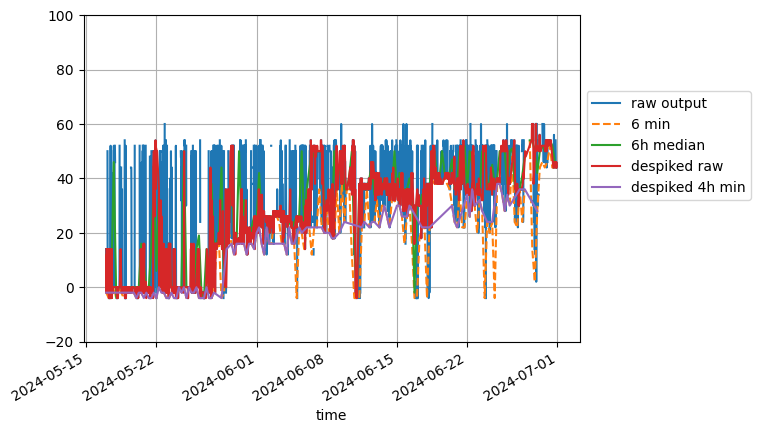

In [56]:
aa.loc['max_index',:].plot(label='raw output')
# aa.loc['max_index',:].plot(label='raw output')

aa_min['max_index'].plot(label='6 min', ls='--')
aa_med['max_index'].plot(label='6h median')

despike_raw.plot(label='despiked raw')
despike_aa.plot(label='despiked 4h min')
# despike_raw.plot(label='despiked raw')
# plt.plot(days, modal_height, label='modal')
plt.legend(loc='center left', bbox_to_anchor=(1,.6))
# plt.xlim(datetime(2024,5,17), datetime(2024,7,1))
plt.ylim(-20,100)
plt.grid()
plt.show()


In [57]:
despike_raw = despike_rolling(aa_min['max_index'],window=4*18, threshold=.6) #window=4*18, threshold=1)

In [371]:
## save to csv for comparison with other data/notebook
despike_raw.to_csv('Raven2024_SIMBA_sfc_id_v2_despiked-18h-1threshold_0.005pval_20250325_v10_top.csv')


### Checking surface as compared to old surface ID

In [58]:
import math

def round_up_to_even(f):
    if np.isnan(f):
        return np.nan
    else:
        return math.ceil(f / 2.) * 2

def round_down_to_even(f):
    if np.isnan(f):
        return np.nan
    else:
        return 2 * (f // 2)

In [59]:
with np.load('/home/asledd/ICECAPS/Raven_SIMBA_sfc-id_max-T-grad.npz') as npz:
    simba_sfc_heights = np.ma.MaskedArray(**npz)

## I know this has 15 minute time steps, so average over several hours
kernel_avg_hrs= [1./(4*6+1)]*(4*6+1)

## broke convolve when updating cmocean; np.convolve has weird edge effects
# simba_sfc = convolve(simba_sfc_heights, kernel_avg_hrs, boundary='extend')
N = 4*6+1
simba_sfc = np.convolve(simba_sfc_heights, np.ones(N)/N, mode='same')

simba_sfc = np.ma.masked_invalid([round_up_to_even(height) for height in simba_sfc]) ## can also do round_down_to_even()
# simba_sfc = np.ma.masked_where(season_data['dates']<datetime(2024,5,15,3), simba_sfc) # masked weird edges
# simba_sfc = np.ma.masked_where(season_data['dates']>=datetime(2024,8,22,21), simba_sfc)

## this was a day with quick accumulation that gets unrealistically smoothed in the surface height
# simba_sfc = np.ma.masked_where((season_data['dates']>=datetime(2024,6, 25))&(season_data['dates']<datetime(2024,6, 26)), simba_sfc)


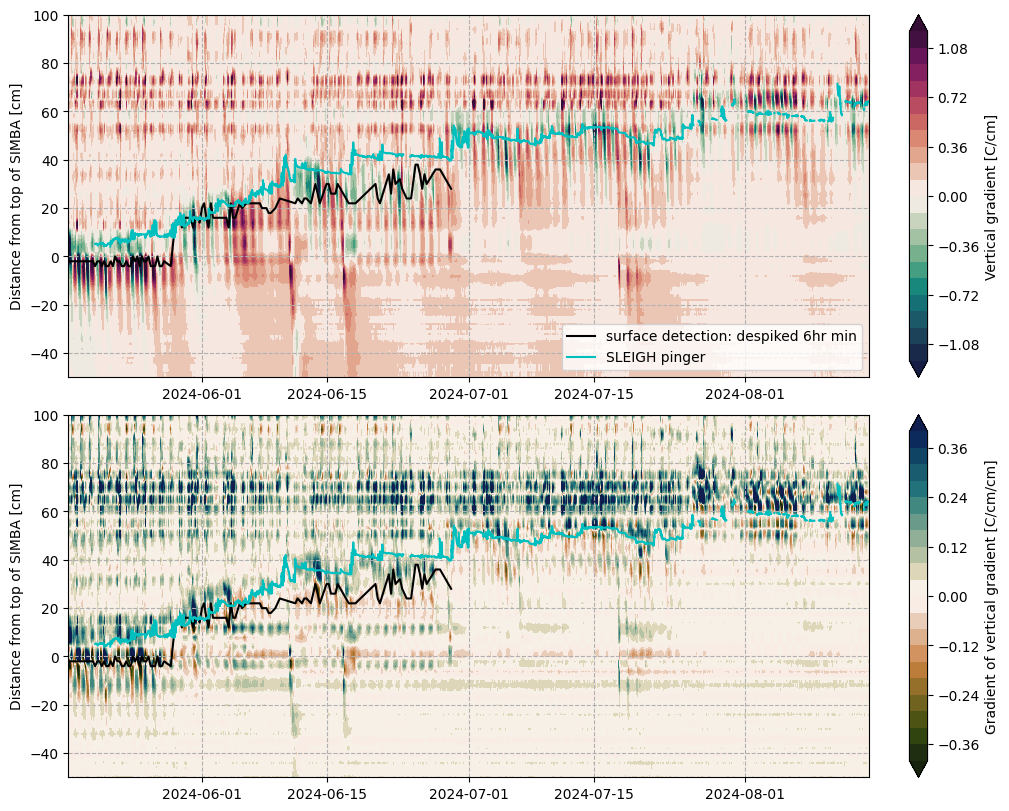

In [64]:

fig, axs = plt.subplots(2, figsize=(10,8), sharey=True, constrained_layout=True)


cb = axs[0].contourf(simba_dates, simba_heights, np.swapaxes(vert_grad,0,1),
                cmap=cmocean.cm.curl, levels=np.linspace(-1.2,1.2,21), extend='both')
plt.colorbar(cb, label='Vertical gradient [C/cm]', ax=axs[0])

second_vert_profiles = np.ma.masked_outside(second_vert_grad,-200,200)
cb = axs[1].contourf(simba_dates, simba_heights, np.swapaxes(second_vert_grad,0,1),
                cmap=cmocean.cm.tarn, levels=np.linspace(-.4,.4,21), extend='both')
plt.colorbar(cb, label='Gradient of vertical gradient [C/cm/cm]', ax=axs[1])


# axs[0].set_ylim(-40, 40) ## if you look at the full profile you can see when/where the surface accumulated along the rest of it

for ax, c in zip(axs.ravel(),['k','k']):
    ax.plot(despike_aa.index,despike_aa.values , c=c, label='surface detection: despiked 6hr min')
    # ax.plot(despike_raw.index,despike_raw.values , c='limegreen', label='surface detection: despiked raw')
    # ax.plot(days,modal_height, c='limegreen', label='24h mode')
    
    # ax.plot(season_data['dates'], simba_sfc, c='k', label='old method', lw=1)
    # ax.plot(season_data['dates'], simba_sfc-6., c='gray', ls='--')

    # ax.axhline(y=-350, c='k', ls='--') ## initial thermistor at the surface when the instrument was installed
    ax.grid(ls='--')
    ax.set_ylabel('Distance from top of SIMBA [cm]')
    ax.set_ylim(-50,100)
    # ax.set_xlim(datetime(2024,5,17), datetime(2024,7,1))
    ax.plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], label='SLEIGH pinger', c='c')

axs[0].legend(loc='lower right')
plt.show()

### Check how the different sections align with pinger

In [62]:
from datetime import timedelta

In [63]:
# turn into function later
asfs_filepath = '/psd3data/arctic/raven_process/asfs/2_level_product/'
asfs_lev2_files = glob.glob(asfs_filepath+'seb.level2.0.melt-sleighsfs.10min.*.nc')
asfs_lev2_files.sort()
# asfs_lev2_files = asfs_lev2_files[12:] # early files don't have skin_temp_surface?

# vaisala_T_Avg = average of the air temperature during the 1 min averaging interval

lev1_slow_vars = ['snow_depth_qc','snow_depth','base_time','time']

asfs_data_lev2 = {}

for fname in asfs_lev2_files[:]:
    print(fname)

    fdic = load_netcdf(fname, lev1_slow_vars)
    # print(fdic['time_unit'])
    fstart_time = datetime.strptime(fdic['time_unit'], 'seconds since %Y-%m-%dT%H:%M:%S.000000')
    fdic['dates'] = np.asarray([fstart_time+timedelta(seconds=int(m)) for m in fdic['time']])

    for var in lev1_slow_vars[:-2]+['dates']:
        if var not in asfs_data_lev2:
            asfs_data_lev2[var] = fdic[var]
        else:
            asfs_data_lev2[var] = np.ma.concatenate( (asfs_data_lev2[var], fdic[var]), axis=0 )


/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240520.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240521.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240522.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240523.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240524.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240525.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240526.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240527.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240528.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb

In [373]:
surface_ids = {}



for section in ['top','bottom']:
    surface_ids[section] = {}
    # if section=='bottom':
    #     # fname = 'Raven2024_SIMBA_sfc_id_v2_despiked-18h-1threshold_20250325_fixedagain_bottom.csv'
    if section=='bottom':
        fname = 'Raven2024_SIMBA_sfc_id_v2_despiked-18h-1threshold_0.001pval_20250325_v10_bottom.csv'
    else:
        # fname = 'Raven2024_SIMBA_sfc_id_v2_6hrmin-despiked-18h-1threshold_20250325_fixedagain_'+section+'.csv'
        # fname = 'Raven2024_SIMBA_sfc_id_v2_6hrmin-despiked-18h-1threshold_0.001pval_20250325_v10_'+section+'.csv'
        # fname = 'Raven2024_SIMBA_sfc_id_v2_6hrmin-despiked-18h-1threshold_20250325_fixedagainmore_'+section+'.csv'
        fname = 'Raven2024_SIMBA_sfc_id_v2_despiked-18h-1threshold_0.005pval_20250325_v10_top.csv'
    # fname = 'Raven2024_SIMBA_sfc_id_v2_6hrmin-despiked-18h-1threshold_20250325_'+section+'.csv'

    df = pd.read_csv('/home/asledd/ICECAPS/'+fname) 
    surface_ids[section]['dates'] = np.array([datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df['time'].values])       
    surface_ids[section]['surface'] = df['max_index'].values


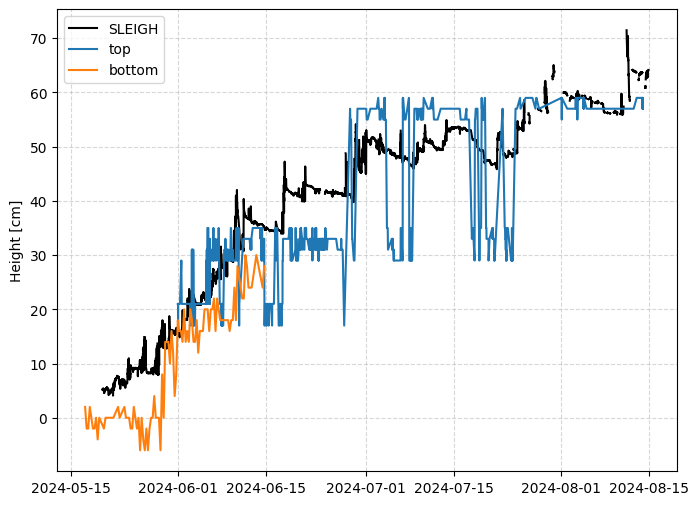

In [374]:
fig, ax = plt.subplots(1, figsize=(8,6))
plt.plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth'], label='SLEIGH', c='k')
for section in surface_ids:
    if section=='top':
        plt.plot(surface_ids[section]['dates'], 
                 np.ma.masked_where(surface_ids[section]['dates']<datetime(2024,6,1), surface_ids[section]['surface']),
                 label=section)
    elif section=='bottom':
        plt.plot(surface_ids[section]['dates'], 
                 np.ma.masked_where(surface_ids[section]['dates']>datetime(2024,6,15), surface_ids[section]['surface']),
                 label=section)        
plt.ylabel('Height [cm]')
plt.legend(loc='best')
plt.grid(ls='--', alpha=.5)
plt.show()